# Notebook for finding average number of HIST severe hail days per year

### Import necessary libraries (xarray for resampling, cartopy for plotting)

In [1]:
import numpy as np
import netCDF4 as nc
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

## Import WRF HIST dataset. Contains 15 years of hist data (1990-2005) at hourly intervals (00Z-00Z) for 366 Julian calendar days

In [ ]:
ds = xr.open_mfdataset('/home/scratch/ahaberlie/AFWA_HAIL/HIST/*/HAIL_MAX2D_historical_*.nc') #This dataset is used for 00Z-00Z sev hail day count

In [ ]:
ds #Print out the dataset

### Import netcdf file containing lat/lon coords for WRF files (use this for plotting later)

In [2]:
coords = xr.open_dataset('lat_lon.nc') #Open .nc file containing WRF lat/lon coords

### Assign lat/lon coords from file to variables

#### Lat/lon coords contained a third dimension equal to 1, we want to get rid of this and ensure data is 2D

In [3]:
lats = coords.CLAT.values[0, :, :]
lons = coords.CLONG.values[0, :, :]

In [4]:
lats.shape #Check shape of lats/lons to make sure they are 2D

(899, 1399)

### Resample WRF HIST data to find max daily (12Z-12Z) hail size for each day and grid cell

In [ ]:
#ds_hail = ds.resample(Time = '24H', base = 12).max(dim = 'Time') #Use xarray's resample method to resample to convective day and find max convective day values

In [ ]:
#ds_hail #Print out the dataset- should return (5479, 899, 1399) array- max daily data for 15 years (4 leap days) for each lat/lon grid cell

### Save resampled max convective day dataset to netcdf

In [ ]:
#ds_hail.to_netcdf('/home/scratch/jgoodin/hist_daily_max_hail_inches.nc') #Save .nc file to scratch directory

### Open the dataset created above

In [5]:
ds_hail_dailymax_inches = xr.open_dataset('/home/scratch/jgoodin/hist_daily_max_hail_inches.nc') #Open .nc file created in cell above

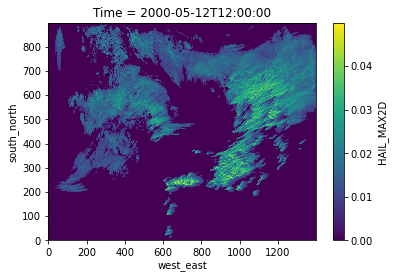

In [6]:
ds_hail_dailymax_inches.sel(Time = '2000-05-12T12').HAIL_MAX2D.plot() #Test plot a day that had hail- make sure file contains data

### Identify grid cells (lat/lon coords) with values that meet severe threshold (>= 1 in [0.0254 m in this case]), assign value of 1 to those that do, 0 to those that don't (not interested in these)

In [4]:
ds_sevr = 1 * (ds_hail_dailymax_inches >= 0.0254) #Assign values of 1 to cells that meet sev criteria, assign days containing 1 cells as value of 1

In [8]:
ds_sevr #Print out sev results

<xarray.Dataset>
Dimensions:     (Time: 5479, south_north: 899, west_east: 1399)
Coordinates:
  * Time        (Time) datetime64[ns] 1990-09-30T12:00:00 ... 2005-09-29T12:0...
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (Time, south_north, west_east) int64 0 0 0 0 0 0 ... 0 0 0 0 0 0

### Repeat this process for >= 4cm HAIL_MAX2D

In [7]:
ds_4cm = 1 * (ds_hail_dailymax_inches >= 0.04) #Assign values of 1 to cells that meet >= 4 cm criteria, assign days containing 1 cells as value of 1

In [9]:
ds_4cm #Print out dataset- returns 5479 days

<xarray.Dataset>
Dimensions:     (Time: 5479, south_north: 899, west_east: 1399)
Coordinates:
  * Time        (Time) datetime64[ns] 1990-09-30T12:00:00 ... 2005-09-29T12:0...
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (Time, south_north, west_east) int64 0 0 0 0 0 0 ... 0 0 0 0 0 0

### NOTE: simulation years are October-September, not January-December. Resampling by year alone will not provide a correct annual statistic

### Resample by year and sum along the 'Time' dimension- provides a count of annual severe hail days for each simulation year. Take mean along 'year' dimension to provide annual sev hail day count for total HIST period

In [7]:
sev_hail_days = ds_sevr.groupby('Time.year').sum(dim = 'Time').mean(dim = 'year') #Groupby year and sum sev days across time dim- take mean to find mean 
#sev hail days across hist

In [8]:
sev_hail_days #Print out resample- should be 2D (899, 1399) and returns mean hist sev hail days

<xarray.Dataset>
Dimensions:     (south_north: 899, west_east: 1399)
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (south_north, west_east) float64 0.0 0.0 0.0 ... 0.125 0.125

### Save annual sev hail days to netcdf

In [9]:
sev_hail_days.to_netcdf('/home/scratch/jgoodin/WRF_HIST_annual_sev_hail_days.nc')

## Repeat for >= 4 cm HAIL_MAX2D

In [10]:
ds_4cm_hail_days = ds_4cm.groupby('Time.year').sum(dim = 'Time').mean(dim = 'year') #Groupby year and sum >= 4cm days across time dim- take mean to find mean 
#sev hail days across hist

In [11]:
ds_4cm_hail_days #Print out resample- should be 2D (899, 1399) and returns mean hist >= 4 cm hail days

<xarray.Dataset>
Dimensions:     (south_north: 899, west_east: 1399)
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (south_north, west_east) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

### Save >= 4 cm hail days to netcdf

In [12]:
ds_4cm_hail_days.to_netcdf('/home/scratch/jgoodin/WRF_HIST_annual_4cm_hail_days.nc')

### Select HAIL_MAX2D variable(s) from above dataset (now in netcdf format) to create a plottable data array

In [10]:
sev_hail_days = sev_hail_days.HAIL_MAX2D

In [15]:
ds_4cm_hail_days = ds_4cm_hail_days.HAIL_MAX2D

## Plot data on map of CONUS

/anaconda3/envs/pyEAE/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


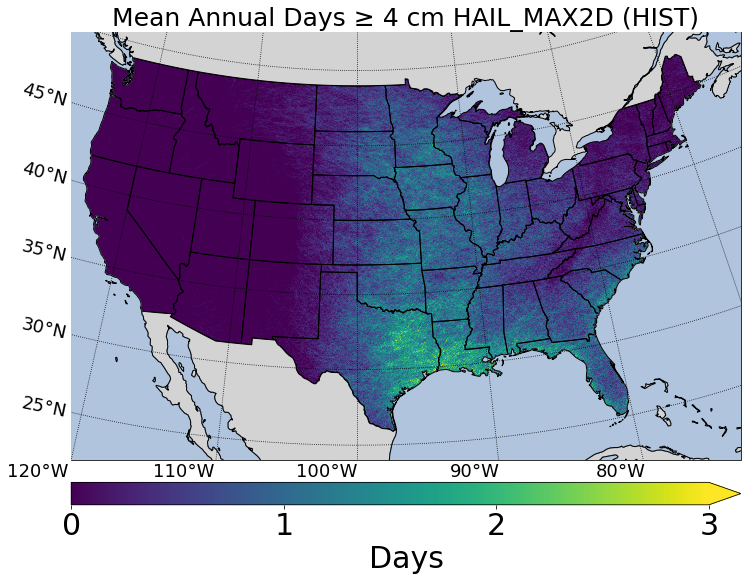

In [18]:
fig = plt.figure(figsize= (12,8)) #Plot a figure
gs1 = gridspec.GridSpec(2, 1, height_ratios=[1, .05], bottom=.05, top=.95, wspace=.1)
map_proj = ccrs.LambertConformal(central_longitude = -100, central_latitude = 35) #Set projection, central lat/lon
ax = plt.subplot(projection = map_proj)
#ax.set_title('Maximum diameter hail for 2005', fontsize = 22)
ax.add_feature(cfeature.LAND.with_scale('10m')) #Add land
countries_shp = shpreader.natural_earth(resolution='50m',
                                     category='cultural',
                                     name='admin_0_countries')
for country, info in zip(shpreader.Reader(countries_shp).geometries(), 
                             shpreader.Reader(countries_shp).records()):
        if info.attributes['NAME_LONG'] != 'United States':

            ax.add_geometries([country], ccrs.PlateCarree(),
                             facecolor='lightgrey', edgecolor='k', zorder=6)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor='k', 
                                                facecolor='None'), zorder=8) 
ax.add_feature(cfeature.BORDERS.with_scale('10m')) #Add state borders
ax.add_feature(cfeature.STATES.with_scale('10m'), facecolor = 'none') #Add US states
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', 
                                                facecolor='lightsteelblue'), zorder=6)
lakes_shp = shpreader.natural_earth(resolution='50m',
                                     category='physical',
                                     name='lakes')
for lake, info in zip(shpreader.Reader(lakes_shp).geometries(), 
                             shpreader.Reader(lakes_shp).records()):
        name = info.attributes['name']
        if name == 'Lake Superior' or name == 'Lake Michigan' or \
           name == 'Lake Huron' or name == 'Lake Erie' or name == 'Lake Ontario':
            
            ax.add_geometries([lake], ccrs.PlateCarree(),
                             facecolor='lightsteelblue', edgecolor='k', zorder=6)
ax.set_extent([240,287,22,50]) #Set lat/lon boundaries
lrFig = ax.pcolormesh(lons, lats, ds_4cm_hail_days, vmax = 3, cmap = 'viridis', transform = ccrs.PlateCarree())
gls = ax.gridlines(draw_labels=True, dms = True, x_inline=False, y_inline=False, color="black", linestyle="dotted", zorder = 10)
gls.top_labels=False
gls.right_labels=False
gls.xlabel_style = {'size': 18, 'rotation': 0}
gls.xpadding = 12.0
gls.ylabel_style = {'size': 18}
plt.title("Mean Annual Days ≥ 4 cm HAIL_MAX2D (HIST)", fontsize = 25)
ax1 = plt.subplot(gs1[1, 0])
cb = plt.colorbar(lrFig, cax = ax1, ticks = [0, 1, 2, 3], orientation = 'horizontal', extend = 'max')
cb.set_label('Days', fontsize = 30)
cb.ax.tick_params(labelsize = 30)
plt.subplots_adjust(bottom=0.12)
plt.savefig('/home/scratch/jgoodin/sev_hail_day_climos/HIST_annual_4cm_hail_days.png')

#### **Another way to find average annual severe hail days using for loop

In [ ]:
"""
for dtime in ds.Time:
    ds_select = ds.sel(Time=dtime)
    svr = 1*(ds_select['HAIL_MAX2D'].values >= 1)
    result =  sev_hail_day + svr
result = result/15
"""

In [ ]:
#result.shape #Result should be 2D (899, 1399)